<a href="https://colab.research.google.com/github/anggara23-dotcom/ProjectML/blob/main/ProjectDWFIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROSES ETL pada Data Penjualan PT. Supermarket Indo Jaya

Proses Install dan Import Library

In [2]:
!pip install pandas sqlalchemy pymysql matplotlib seaborn openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 1.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine


Upload File Excel yang berisi Data Penjualan

In [4]:
from google.colab import files
uploaded = files.upload()   # pilih file Excel
file_path = list(uploaded.keys())[0]

xls = pd.ExcelFile(file_path)
print("Sheet tersedia:", xls.sheet_names)


Saving warehouse_supermart.xlsx to warehouse_supermart.xlsx
Sheet tersedia: ['dim_customer', 'dim_produk', 'dim_store', 'dim_time', 'fact_inventory', 'fact_sales']


Di dalam file excel ini terdapat 6 sheet yang berisi data dari PT. Supermarket Indo Jaya

# Fungsi Cleaning

In [5]:
def normalize_gender(x):
    if pd.isna(x): return 'Unknown'
    s = str(x).strip().lower()
    if s in ('m','male','man','l','laki','laki-laki'): return 'Male'
    if s in ('f','female','woman','perempuan','p'): return 'Female'
    return 'Unknown'

def clean_df(df):
    for c in df.select_dtypes(include=['object']):
        df[c] = df[c].str.strip()
    return df


Disini kita melakukan fungsi cleaning/cleansing yang dimana ini adalah bagian dari prose ETL yaitu T (Transform). yang bertujuan untuk memastikan data rapi, konsisten, dan siap pakai untuk di analisis.

# Extract + Transform

In [6]:
dim_customer = pd.read_excel(xls, sheet_name="dim_customer")
dim_produk   = pd.read_excel(xls, sheet_name="dim_produk")
dim_store    = pd.read_excel(xls, sheet_name="dim_store")
dim_time     = pd.read_excel(xls, sheet_name="dim_time")
fact_inventory = pd.read_excel(xls, sheet_name="fact_inventory")
fact_sales     = pd.read_excel(xls, sheet_name="fact_sales")

# Cleaning khusus gender
dim_customer['gender'] = dim_customer['gender'].apply(normalize_gender)

# Cleaning umum
dim_customer = clean_df(dim_customer)
dim_produk   = clean_df(dim_produk)
dim_store    = clean_df(dim_store)
# dim_time = clean_df(dim_time) # dim_time doesn't have object columns to clean
fact_inventory = clean_df(fact_inventory)
fact_sales     = clean_df(fact_sales)

# Konversi tanggal
dim_time['full_date'] = pd.to_datetime(dim_time['full_date'], errors='coerce')
fact_sales['date_id'] = pd.to_datetime(fact_sales['date_id'], errors='coerce')

print("✅ Data berhasil dibersihkan")

✅ Data berhasil dibersihkan


Data yang dibaca dari file excel yang sudah kita import dan memiliki beberapa lembar kerja (sheet). Yang dimana setiap sheet dimuat kedalam DataFrame pandas yang terpisah, sesuai dengan jenis dimensi atau fakta dalam model data.

Kolom gender pada tabel dim_customer dinormalisasi menggunakan fungsi normalize_gender. Dengan tujuan menyeragamkan nilai gender (Misalnya: "L", "P", "Male", "Female" -> menjadi format standar seperti "Laki-laki", "Perempuan".

Lalu dengan fungsi clean_df() diterapkan pada setiap DataFrame untuk membersihkan data secara umum:


*   Menghapus duplikat
*   Mengisi nilai yang hilang (missing vlue)
*   Membersihkan teks (strip spasi dll)
*   Mengonversi tipe data yang tidak sesuai

kemudiantanggal diubah menjadi tipedata datetime untuk memudahkan analisis waktu.

In [7]:
print(fact_sales.columns)

Index(['sales_id', 'date_id', 'product_id', 'customer_id', 'store_id',
       'quantity', 'unit_price', 'total_amount', 'payment_method'],
      dtype='object')


# Load (Menyimpan hasil ke CSV)

In [8]:
dim_customer.to_csv("dim_customer_clean.csv", index=False)
dim_produk.to_csv("dim_produk_clean.csv", index=False)
dim_store.to_csv("dim_store_clean.csv", index=False)
dim_time.to_csv("dim_time_clean.csv", index=False)
fact_inventory.to_csv("fact_inventory_clean.csv", index=False)
fact_sales.to_csv("fact_sales_clean.csv", index=False)

from google.colab import files
files.download("dim_customer_clean.csv")
files.download("dim_produk_clean.csv")
files.download("dim_store_clean.csv")
files.download("dim_time_clean.csv")
files.download("fact_inventory_clean.csv")
files.download("fact_sales_clean.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File Excel yang sudah di cleansing akan dikonversi ke CSV

Proses konversi dari Excel ke CSV dalam workflow data science merupakan langkah strategis yang didasarkan pada pertimbangan efisiensi dan universalitas. Format Excel, meskipun kaya akan fitur formatting dan formula, justru mengandung kompleksitas yang seringkali menjadi hambatan dalam proses analisis data yang berskala besar. Setiap file Excel membawa serta baggage berupa informasi formatting, style, formula, dan metadata yang sebenarnya tidak diperlukan untuk analisis data inti.

# Analisis + Visualisasi

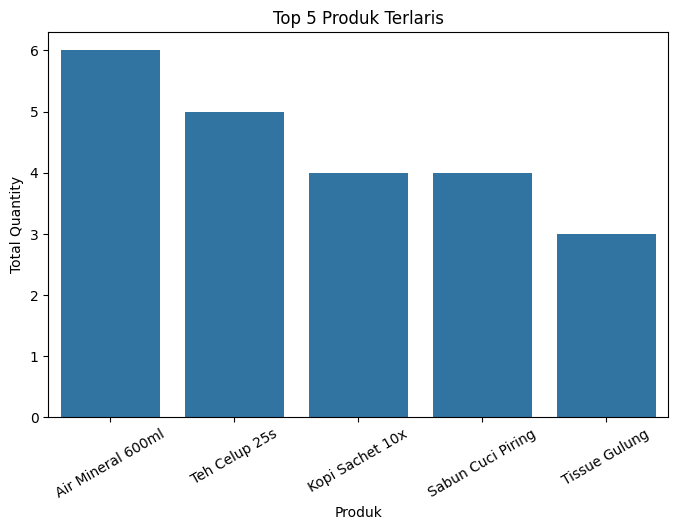

In [9]:
top_produk = fact_sales.groupby("product_id")["quantity"].sum().reset_index()
top_produk = top_produk.merge(dim_produk, on="product_id")
top5 = top_produk.sort_values("quantity", ascending=False).head(5)

plt.figure(figsize=(8,5))
sns.barplot(data=top5, x="product_name", y="quantity")
plt.title("Top 5 Produk Terlaris")
plt.ylabel("Total Quantity")
plt.xlabel("Produk")
plt.xticks(rotation=30)
plt.show()


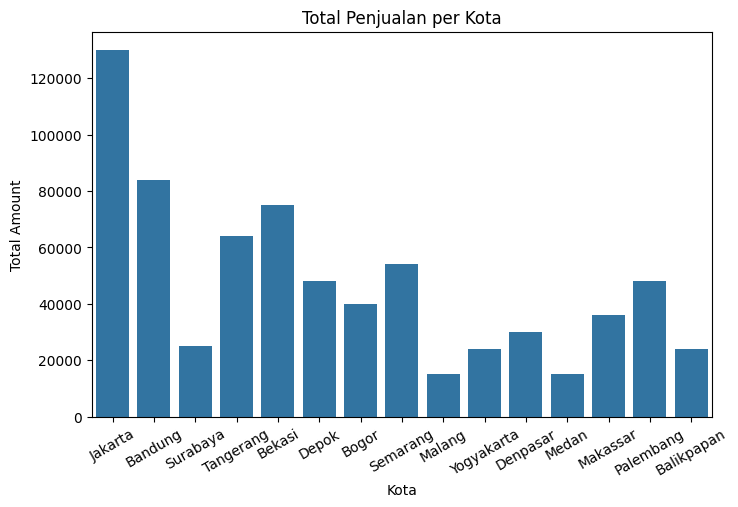

In [10]:
sales_city = fact_sales.groupby("store_id")["total_amount"].sum().reset_index()
sales_city = sales_city.merge(dim_store, on="store_id")

plt.figure(figsize=(8,5))
sns.barplot(data=sales_city, x="city", y="total_amount")
plt.title("Total Penjualan per Kota")
plt.ylabel("Total Amount")
plt.xlabel("Kota")
plt.xticks(rotation=30)
plt.show()


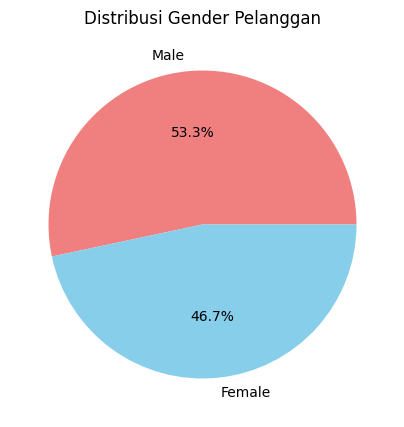

In [12]:
gender_dist = dim_customer["gender"].value_counts()

plt.figure(figsize=(5,5))
gender_dist.plot(kind="pie", autopct="%.1f%%", colors=["lightcoral", "skyblue"])
plt.title("Distribusi Gender Pelanggan")
plt.ylabel("")
plt.show()
